## SAM Playground

In [1]:
import cv2
import numpy as np
import cv2
import numpy as np
from torchvision.ops.boxes import box_convert
from segment_anything import utils
import matplotlib.pyplot as plt
from skimage import io

## First download a Semantic-SAM checkpoint from Huggingface

In [2]:
from huggingface_hub import hf_hub_download
sam_checkpoint = hf_hub_download(repo_id="KarimUmar/semantic_sam", filename="model.pt")

In [3]:
from segment_anything.modeling.semantic_sam import Semantic_SAM
from segment_anything import predictor, automatic_mask_generator

cfg = {
    "model": {
        "checkpoint": sam_checkpoint,
        "model_type" : "vit_l",
        "clip_dim" : 768,
        "device" : "cuda",
        "text_encoder" : True,
        "use_semantic_tokens" : True,
        "use_semantic_hyper_networks" : True
    }
}

model = Semantic_SAM(cfg)
pred = predictor.SamPredictor(model.sam, text_decoder = model.text_decoder)

Initializing Model from Config
Skipping loading of unmatched parameters
_IncompatibleKeys(missing_keys=['temperature'], unexpected_keys=[])


# Create a Classifier

In [4]:
# Semantic-SAM outputs a CLIP aligned semantic prediction, for classifying masks, we can simply constuct a classifier using the same CLIP encoder used 
# During training.

import torch
from PIL import Image
import open_clip
import sys
from segment_anything.eval import zero_shot
import pickle, os
from segment_anything.eval.metadata import  TEMPLATES_2, TEMPLATES_5, OPENAI_IMAGENET_TEMPLATES, COOC_2017_CLASS_NAMES, TEMPLATES_1
from urllib.request import urlopen


# Load openclip model
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='datacomp_xl_s13b_b90k')
tokenizer = open_clip.get_tokenizer('ViT-L-14')
_ = clip_model.to('cuda')

@torch.no_grad()
def build_classifier (
    class_names,
    templates
):
    proompts = [template(class_name) for class_name in class_names for template in templates]
    tokens = tokenizer(proompts).to('cuda')
    classifier = clip_model.encode_text(tokens).float()
    classifier = torch.nn.functional.normalize(classifier)

    # return the tensor reshaped to [n_classes, n_templates, clip_dim]
    return classifier.reshape(len(class_names), len(templates), -1), proompts


@torch.no_grad()
def build_classifier_from_images (
    pil_images
):
    all_features = []
    for class_images in pil_images:
        #for image in class_images:
        class_images = [preprocess(x).unsqueeze(0).to('cuda') for x in class_images]
        image_features = torch.stack([clip_model.encode_image(image) for image in class_images])
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        all_features += [image_features.squeeze()]
    # return the tensor reshaped to [n_classes, n_templates, clip_dim]
    return torch.stack(all_features)

## Create a Text classifier

#### To use Semantic-SAM for any downstream applications, it can be usefull to classify masks. This requires first building a classifier, which is very simple and can be made either by supplying example images or class names explicitly

In [5]:

class_names = ["airplane", "jet engine", "wing", "cockpit"]
classifier = {
    "weights" : build_classifier(class_names, TEMPLATES_5)[0],
    "classes" : class_names
}

# Automatic Mask Generation

In [82]:
# Switch between some pre made examples

EXAMPLE_ID = 2

(-0.5, 679.5, 465.5, -0.5)

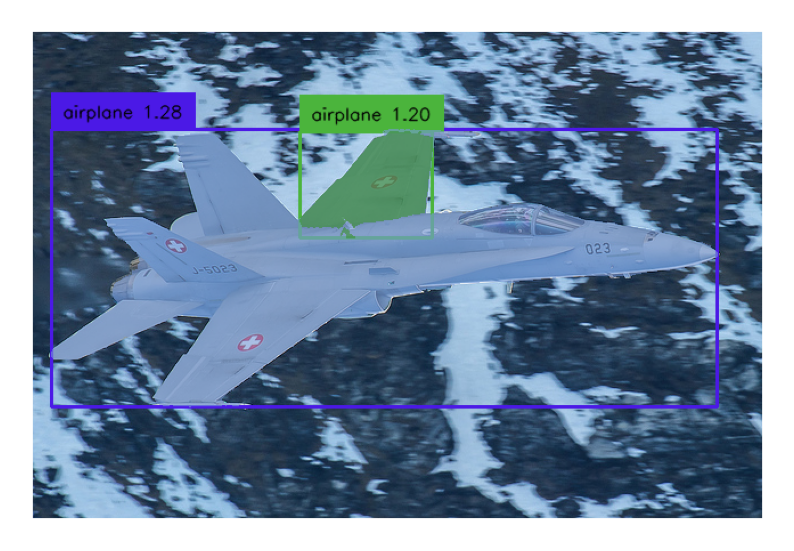

In [95]:
class_names = [
    ["car", "car window", "wheel", "dog"],
    ["atv", "person", "helmet", "wheel"],
    ["airplane", "airplane wings", "airplane nose", "airplane rudder", "cockpit"],
]
classifier = { 
    "weights" : build_classifier(class_names[EXAMPLE_ID], TEMPLATES_5)[0],
    "classes" : class_names[EXAMPLE_ID]
}

path = [
    "http://images.cocodataset.org/val2017/000000065485.jpg",
    "http://images.cocodataset.org/val2017/000000204186.jpg",
    "http://images.cocodataset.org/val2017/000000424776.jpg"
]

# Read image and add border so bounding boxes are not cut off
image_array = np.asarray(ImageOps.expand(Image.open(urlopen(path[EXAMPLE_ID])),border=20,fill='white'))
image = cv2.cvtColor(
    image_array, 
    cv2.COLOR_BGR2RGB
)

mask_generator = automatic_mask_generator.SamAutomaticMaskGenerator(
    model.sam, 
    classifier = classifier, 
    text_decoder = model.text_decoder, 
    points_per_batch = 64,
    points_per_side = 16, 
)

mask_generator.predictor = pred
masks = mask_generator.generate(
    image, 
    filter = True)

if len(masks) > 0:
    annotated_frame = utils.annotate_and_draw (image, masks)

    plt.figure(figsize=(10,10))
    plt.imshow(Image.fromarray(annotated_frame))
else:
    print("No masks predicted!!")
    plt.imshow(image)
    
plt.axis("off")

## Automatic Mask generation with image classifier

### Create an image classifier

Class Name: cat


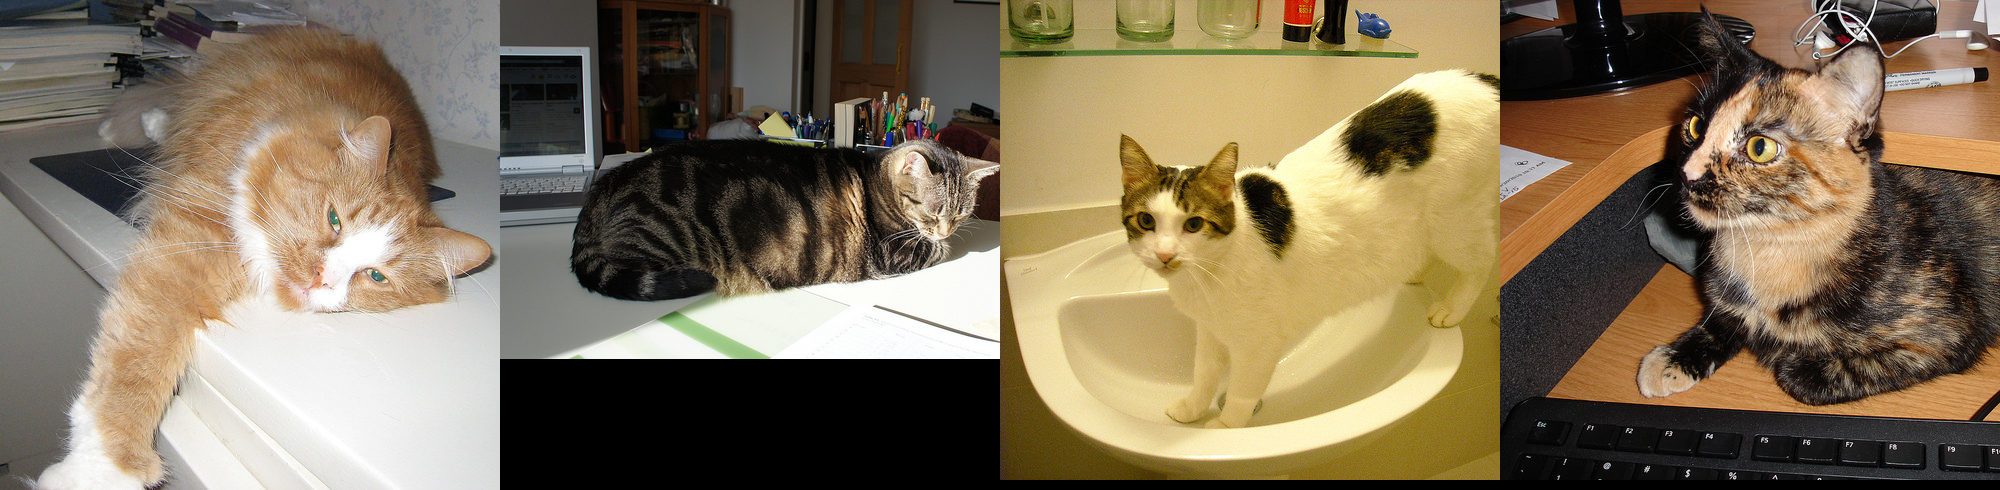

Class Name: dog


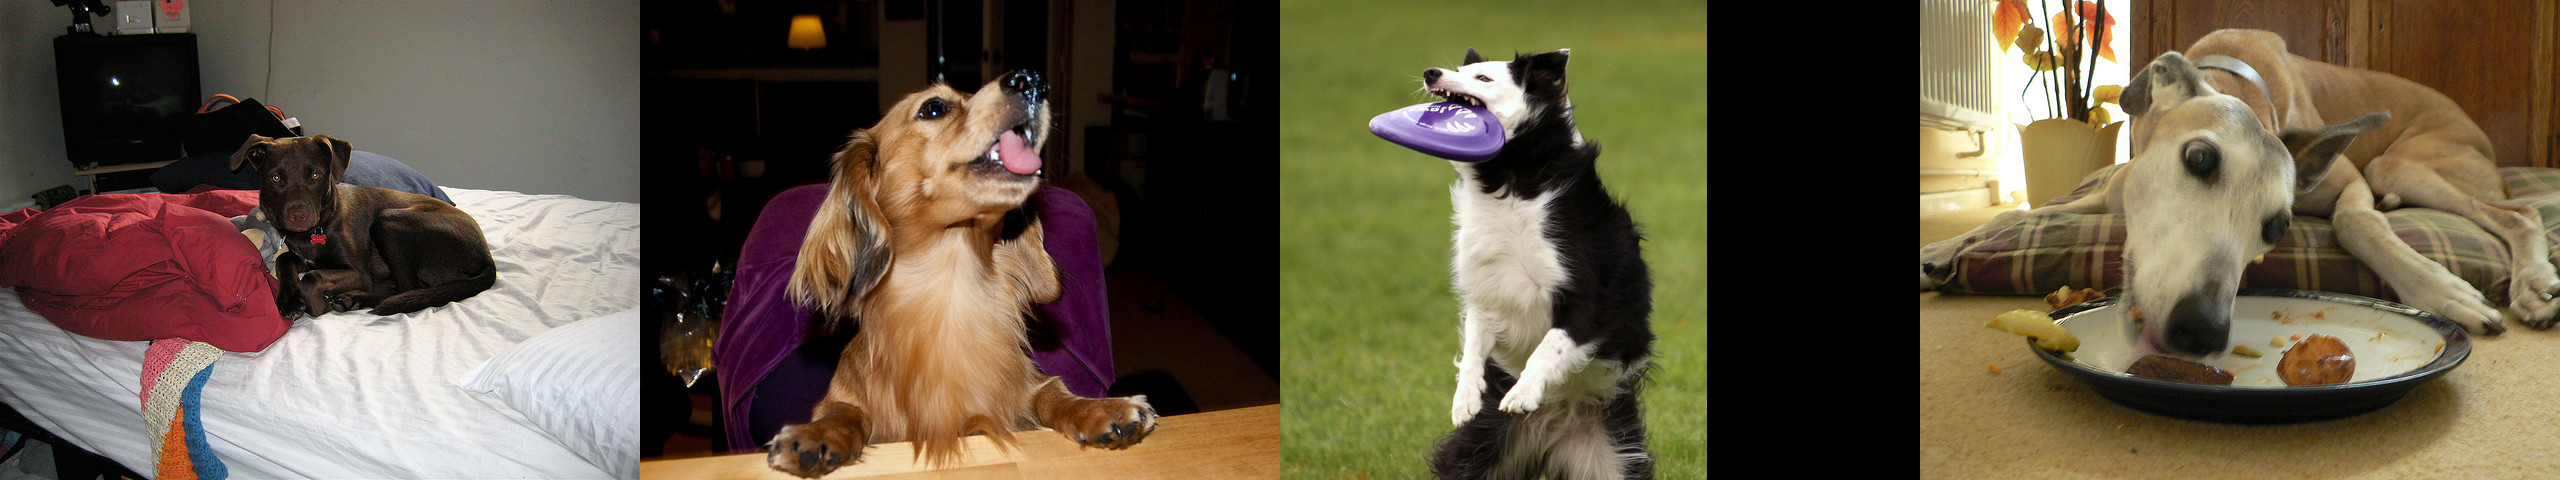

In [69]:
VIZUALIZE_CLASSIFIER = True
class_names = ["cat", "dog"] ## Only used for vizualization

images = [
    [
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000058111.jpg")),
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000112798.jpg")),
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000227044.jpg")),   
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000287649.jpg")),   
    ]
    ,
    [
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000072813.jpg")),
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000082807.jpg")),   
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000138492.jpg")), 
        Image.open(urlopen("http://images.cocodataset.org/val2017/000000267300.jpg")), 
    ]
    
    
]

image_classifier = {
    "weights" : build_classifier_from_images(images),
    "classes" : class_names
}

if VIZUALIZE_CLASSIFIER:
    #Vizualize images in a classifier
    import cv2
    from PIL import Image, ImageDraw, ImageFont
    from IPython.display import display

    def image_grid(imgs, rows, cols):
        assert len(imgs) == rows*cols

        w, h = imgs[0].size
        grid = Image.new('RGB', size=(cols*w, rows*h))
        grid_w, grid_h = grid.size

        for i, img in enumerate(imgs):
            grid.paste(img, box=(i%cols*w, i//cols*h))
        return grid

    for class_name, images_ in zip(class_names, images):
        print(f"Class Name: {class_name}")
        display(image_grid(images_, rows=1, cols=4))

(-0.5, 639.5, 456.5, -0.5)

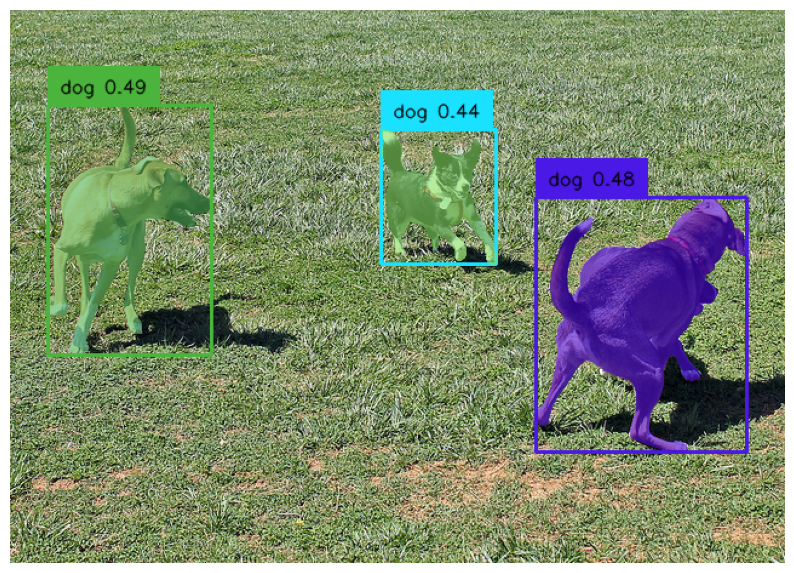

In [72]:
# Note this typically requires reducing semantic threshold to work well
path = "http://images.cocodataset.org/val2017/000000269113.jpg"


# Read image and add border so bounding boxes are not cut off
image = cv2.cvtColor(io.imread(path), cv2.COLOR_BGR2RGB)

mask_generator = automatic_mask_generator.SamAutomaticMaskGenerator(
    model.sam, 
    classifier = image_classifier, 
    text_decoder = model.text_decoder, 
    points_per_batch = 64,
    points_per_side = 16, 
)

mask_generator.predictor = pred
masks = mask_generator.generate(
    image, 
    filter = True,
    ## This typically requires reducing the semantic threshold to work well!!!!!!
    semantic_threshold = 0.4)

if len(masks) > 0:
    annotated_frame = utils.annotate_and_draw (image, masks)

    plt.figure(figsize=(10,10))
    plt.imshow(Image.fromarray(annotated_frame))
else:
    print("No masks predicted")
    plt.imshow(image)
    
plt.axis("off")

## Failure cases!!

(-0.5, 639.5, 426.5, -0.5)

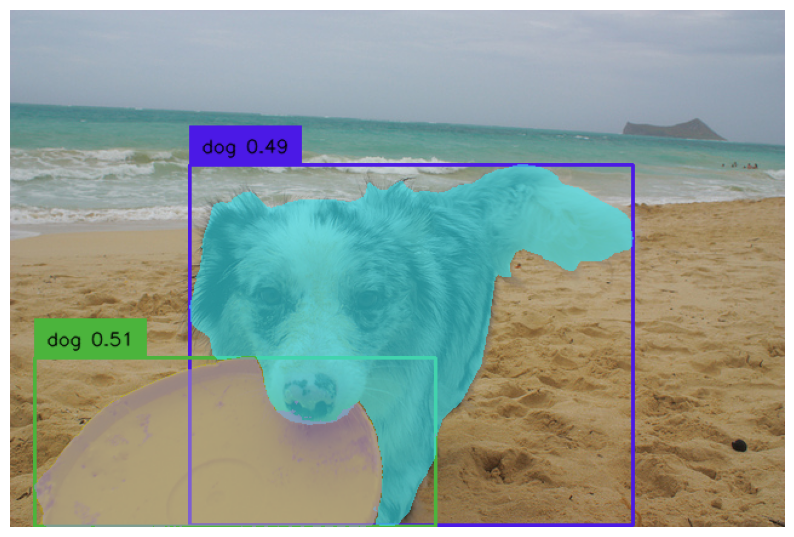

In [74]:
# 1. Be careful what example images are provided, note the frisbee in one of the image classifiers, this leads Semantic-SAM believing a frisbee is a dog


path = "http://images.cocodataset.org/val2017/000000052891.jpg"

# Read image and add border so bounding boxes are not cut off
image = cv2.cvtColor(io.imread(path), cv2.COLOR_BGR2RGB)

mask_generator = automatic_mask_generator.SamAutomaticMaskGenerator(
    model.sam, 
    classifier = image_classifier, 
    text_decoder = model.text_decoder, 
    points_per_batch = 64,
    points_per_side = 16, 
)

mask_generator.predictor = pred
masks = mask_generator.generate(
    image, 
    filter = True,
    ## This typically requires reducing the semantic threshold to work well!!!!!!
    semantic_threshold = 0.4)

if len(masks) > 0:
    annotated_frame = utils.annotate_and_draw (image, masks)

    plt.figure(figsize=(10,10))
    plt.imshow(Image.fromarray(annotated_frame))
else:
    print("No masks predicted")
    plt.imshow(image)
    
plt.axis("off")

(-0.5, 679.5, 464.5, -0.5)

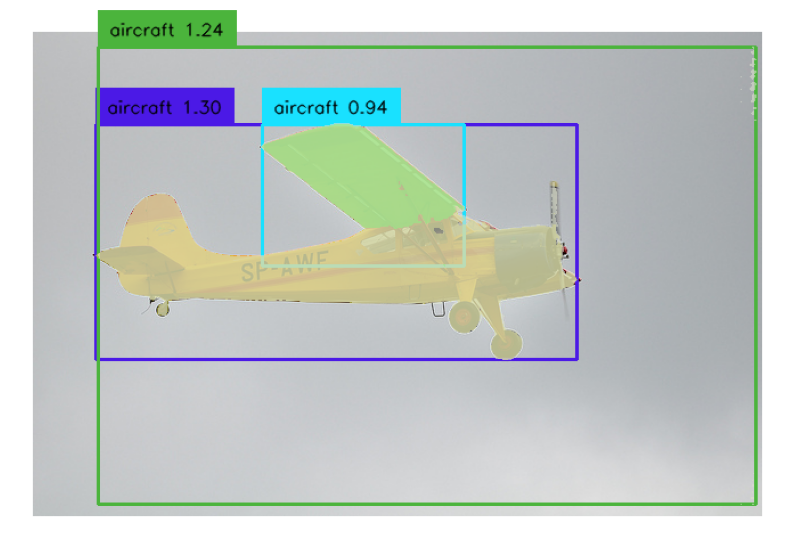

In [99]:
# Subparts are often given the label of the whole part
class_names = [
    "aircraft", "wing", "propellor", "cockpit", "wheel",
]
classifier = { 
    "weights" : build_classifier(class_names, TEMPLATES_5)[0],
    "classes" : class_names
}

path = "http://images.cocodataset.org/val2017/000000052017.jpg"

# Read image and add border so bounding boxes are not cut off
image_array = np.asarray(ImageOps.expand(Image.open(urlopen(path)),border=20,fill='white'))
image = cv2.cvtColor(
    image_array, 
    cv2.COLOR_BGR2RGB
)

mask_generator = automatic_mask_generator.SamAutomaticMaskGenerator(
    model.sam, 
    classifier = classifier, 
    text_decoder = model.text_decoder, 
    points_per_batch = 64,
    points_per_side = 16, 
)

mask_generator.predictor = pred
masks = mask_generator.generate(
    image, 
    filter = True)

if len(masks) > 0:
    annotated_frame = utils.annotate_and_draw (image, masks)

    plt.figure(figsize=(10,10))
    plt.imshow(Image.fromarray(annotated_frame))
else:
    print("No masks predicted!!")
    plt.imshow(image)
    
plt.axis("off")

(-0.5, 679.5, 496.5, -0.5)

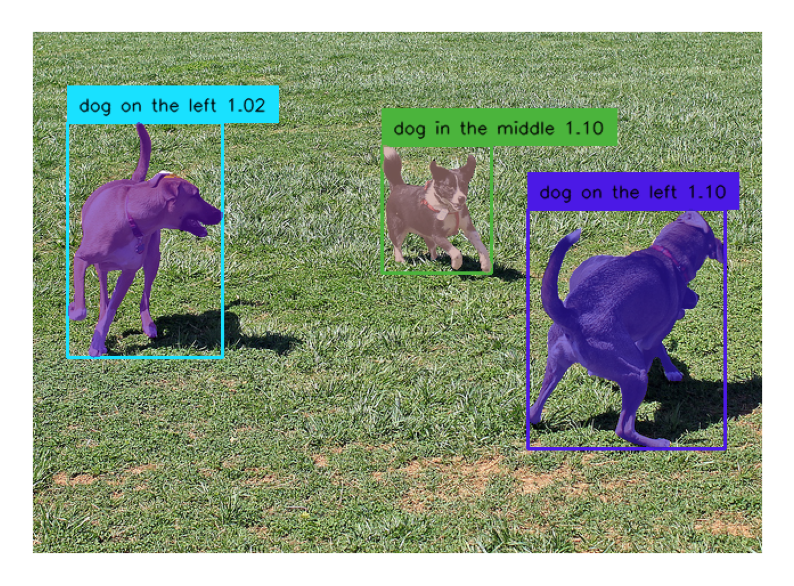

In [100]:
# No spatial understanding

class_names = [
    "dog in the middle",
    "dog on the right",
    "dog on the left",
]
classifier = { 
    "weights" : build_classifier(class_names, TEMPLATES_5)[0],
    "classes" : class_names
}

path = "http://images.cocodataset.org/val2017/000000269113.jpg"

# Read image and add border so bounding boxes are not cut off
image_array = np.asarray(ImageOps.expand(Image.open(urlopen(path)),border=20,fill='white'))
image = cv2.cvtColor(
    image_array, 
    cv2.COLOR_BGR2RGB
)

mask_generator = automatic_mask_generator.SamAutomaticMaskGenerator(
    model.sam, 
    classifier = classifier, 
    text_decoder = model.text_decoder, 
    points_per_batch = 64,
    points_per_side = 16, 
)

mask_generator.predictor = pred
masks = mask_generator.generate(
    image, 
    filter = True)

if len(masks) > 0:
    annotated_frame = utils.annotate_and_draw (image, masks)

    plt.figure(figsize=(10,10))
    plt.imshow(Image.fromarray(annotated_frame))
else:
    print("No masks predicted!!")
    plt.imshow(image)
    
plt.axis("off")